Simple plotting tutorial
========================

Note: Images get shrunken and don't display well on readthedocs. You can open
the full-resolution version by right clicking and selecting "open image in new
tab".

Welcome to the RNAvigate tutorials. Here I will demonstrate and explain some
of the functionality of RNAvigate. In this Jupyter Notebook example, we'll
explore:

* [Importing RNAvigate](#importing-rnavigate)
* [Loading data](#loading-data)
* [Using plotting functions](#using-plotting-functions)
  * [ShapeMapper2 QC Plot](#quality-control-plot)
  * [Classic ShapeMapper2 Profiles](#shapemapper2-plots)
  * [Skyline (Step) Plots](#skyline-plots)
  * [Arc Plots](#arc-plots)
  * [Circle Plots](#circle-plot)
  * [Secondary Structure Diagrams](#secondary-structure-diagrams)
  * [Interactive 3D Molecules](#3d-molecule-interactive-plots)
  * [Heatmaps and Contour Plots](#heatmap-and-contour-plot)
  * [Distance Histograms](#distance-histograms)

Importing RNAvigate
-------------------

This section is very simple. We tell Jupyter that we need access to the
rnavigate code, and give it an alias `rnav` with `import rnavigate as rnav`.

In [1]:
import rnavigate as rnav

Loading data
------------

RNAvigate is built around the `Sample` object, which defines the datasets
that are associated to a particular experimental sample. The first step to
quickly performing vizualization and analysis is to create a `Sample` object.
All of the parameters are optional. Here is a breif explanation of each:

In the example below, we have already performed SHAPE-MaP, RING-MaP, PAIR-MaP, RNAstructure partition and ProbabilityPlot.

In [2]:
example = rnav.Sample(
    sample="Example Data",
    log="data/example2_shapemapper_log.txt",
    shapemap="data/example2_rnasep_profile.txt",
    ringmap="data/example2-rnasep.corrs",
    pairmap="data/example2-rnasep-pairmap.txt",
    pairprob="data/rnasep.dp",
    ct="data/RNaseP.ct",
    ss="data/RC_CRYSTAL_STRUCTURE.xrna",
    pdb={"filepath": "data/3dhsCrystal_PlusLoops.pdb",
         "chain": "A"})

Using plotting functions
------------------------

Once we have define a `MaP.Sample` and given it a name (above we named ours
`example`), we have access to many plotting functions. Depending on the data
that we provided, some may not work. Here is the general anatomy of a plotting
call:

```python
plot = example.plot_plottype(data="datatype")
```

or to plot multiple samples in a single image:

```python
plot = rnav.plot_plottype_multisample(
    samples=[example_1, example2],
    data="datatype")
```

- `plottype` is one of the plottypes discussed below.
- each plot type accepts different types of `data`
- `"datatype"` matches a data type provided when creating your rnav.Sample.

Below, I'll breifly explain each plot type and the data and other options
available to it.

### Quality control plot

This plot only applies to `log` and `shapemap`, and so it accepts no options.

This plot renders three panels:

1) Mutations per molecule: this rightward shift of the blue line (Modified)
  tells us that there is sufficient mutation rate above background. The blue
  line is centered at about 4.5, which is sufficient but slightly low for
  correlations and deconvolution (RING-MaP, PAIR-MaP, DANCE-MaP). This number
  will shift based on the length of the reads, the reactivity of the probe, and
  the degree of base-pairing or rigidness of the RNA structure.
2) Read lengths: Both blue and orange bars contain the expected read length for
  our amplicon with few shorter fragments, which are likely the result of sequencing
  quality dips that prevent R1 and R2 merging. Fragmented data sets will have a
  broader distribution.
3) Per-nucleotide mutation rate distribution: This split violin chart shows that
  the Untreated sample's per-nucleotide mutation rate is clustered tightly near
  zero. In contrast the Modified sample has mutation rates approaching 15%.

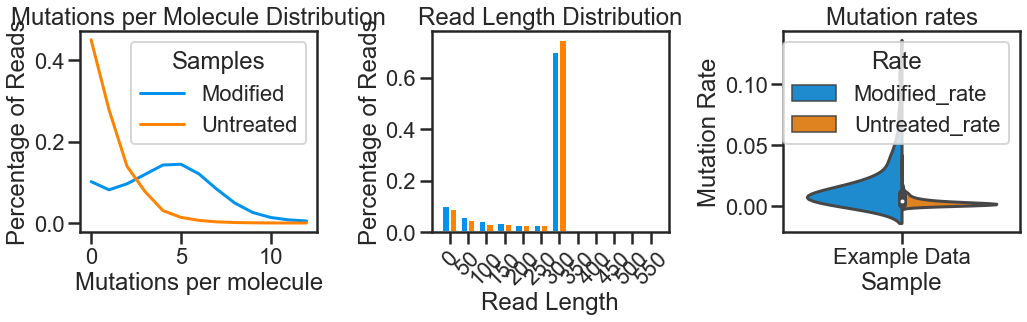

In [3]:
plot = example.plot_qc()

### ShapeMapper2 plots

Next we'll want to take a look at our profile information more in-depth. The standard ShapeMapper2 plots give us a lot of insight.

1) The first panel gives us a basic view of where the RNA is most reactive. The pattern below is indicative of a rigid and highly base-paired RNA.
2) The second panel gives us raw mutation rates for the untreated and modified RNA samples. Here we see a large signal over background.
3) The third panel tells us how many reads we collected for this RNA. Here we have 800,000 reads evenly covering the entire RNA. This will be sufficient for correlation and deconvolution.

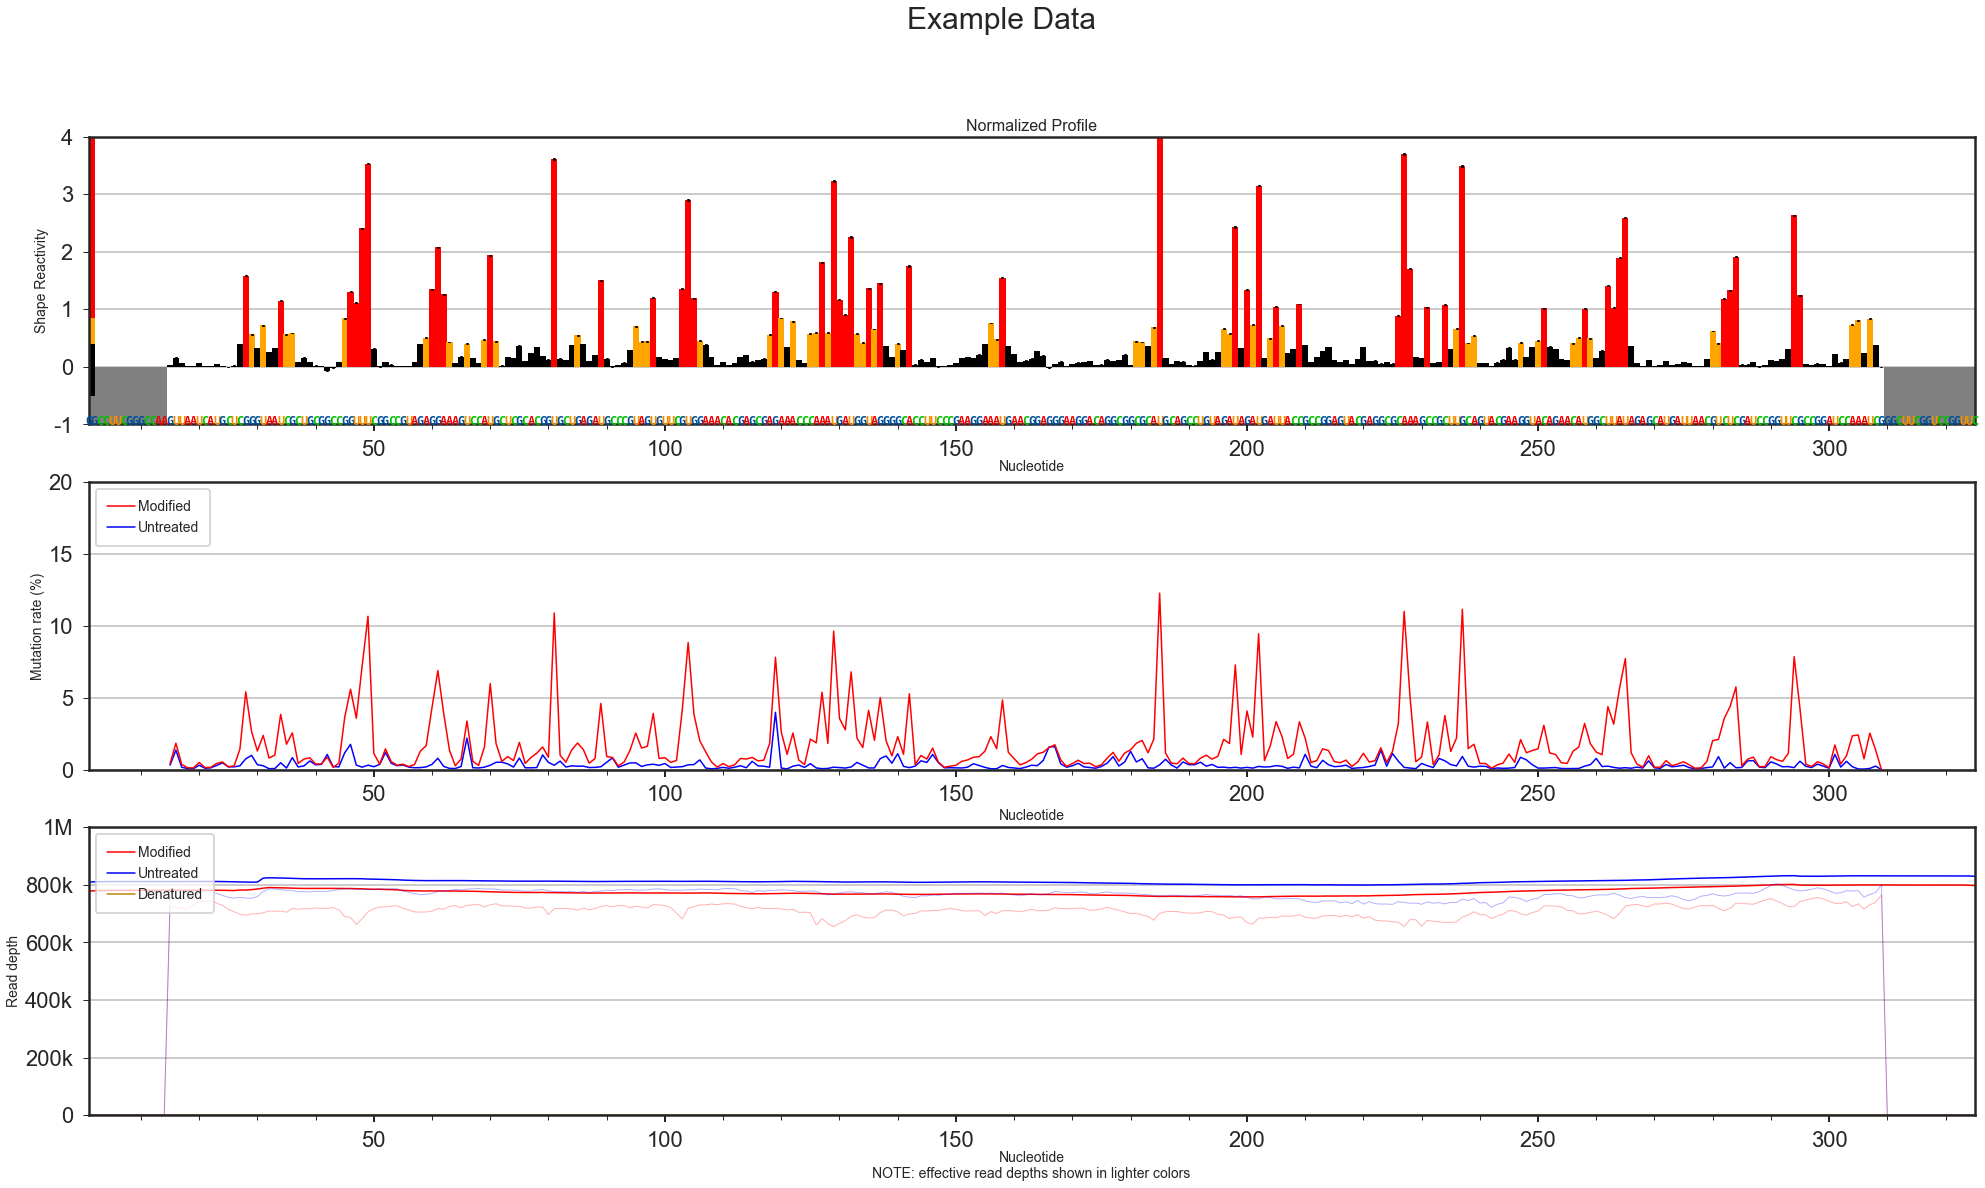

In [4]:
plot = example.plot_shapemapper()

### Skyline plots

Another way to view this info quickly and more flexibly is the skyline plot,
also called a step plot. With these, you can view any per-nucleotide
information. These plots are most useful for comparing multiple columns or
samples. Below I show how we can show the same data from the middle plot
above using skyline.

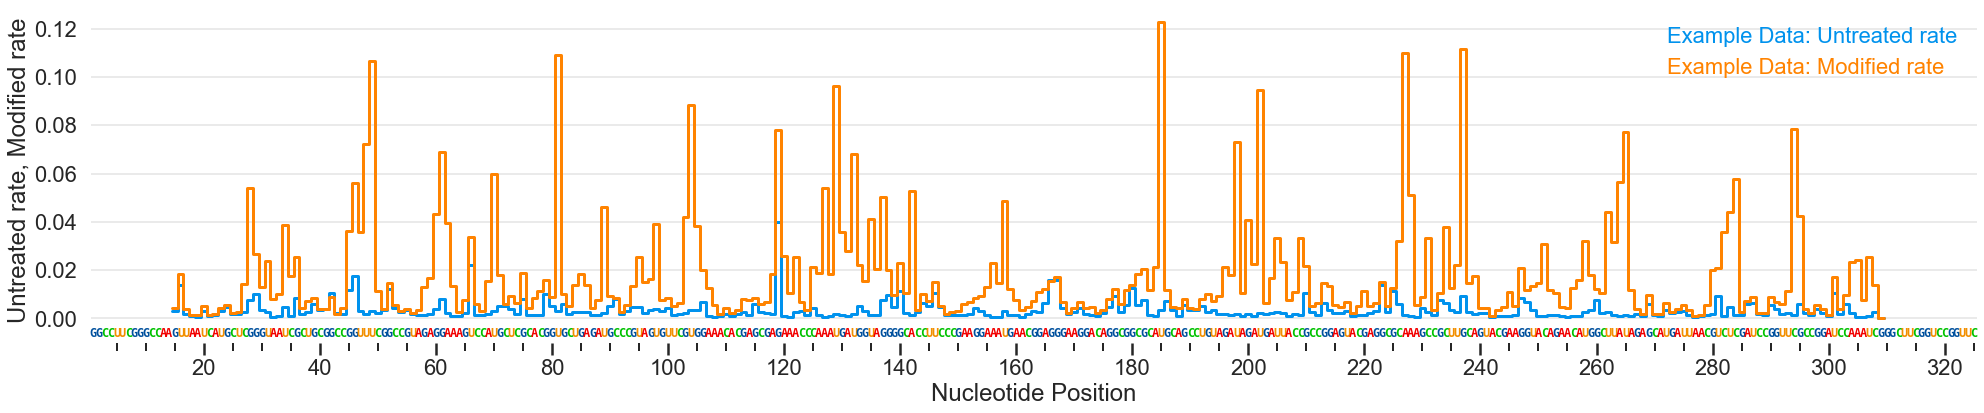

In [5]:
# plot = example.plot_skyline(columns="Norm_profile")
plot_2 = example.plot_skyline(columns=["Untreated_rate", "Modified_rate"])
# plot_3 = example.plot_skyline(columns=["Untreated_effective_depth", "Modified_effective_depth"])

### Arc plots

Arc plots are a very flexible way to visualize multiple layers of information.
One useful way to assess a structure is to plot the MFE over the pairing
probabilities. MFEs provide a simple view of what the structure might look
like, but pairing probabilities reveal uncertainty and nuance in the MFE
prediction.

By default, `plot_arcs`  shows the `"ct"` and `"profile"` information.
Equivalent to calling:

```python
example.plot_arcs(ct="ct", profile="profile")
```

The `ct` structure is shown on top, and the `profile` on the middle track.
I'll add `interactions="pairprob"` to plot my pairing probabilities on bottom.
`interactions` can be any data which links two nucleotides, including
correlations ('ringmap', 'pairmap', 'allcorrs'), SHAPE-JuMP data ('shapejump'),
pairing-probabilities ('pairprob'), or base-pairing ('ct', 'compct', or 'ss').

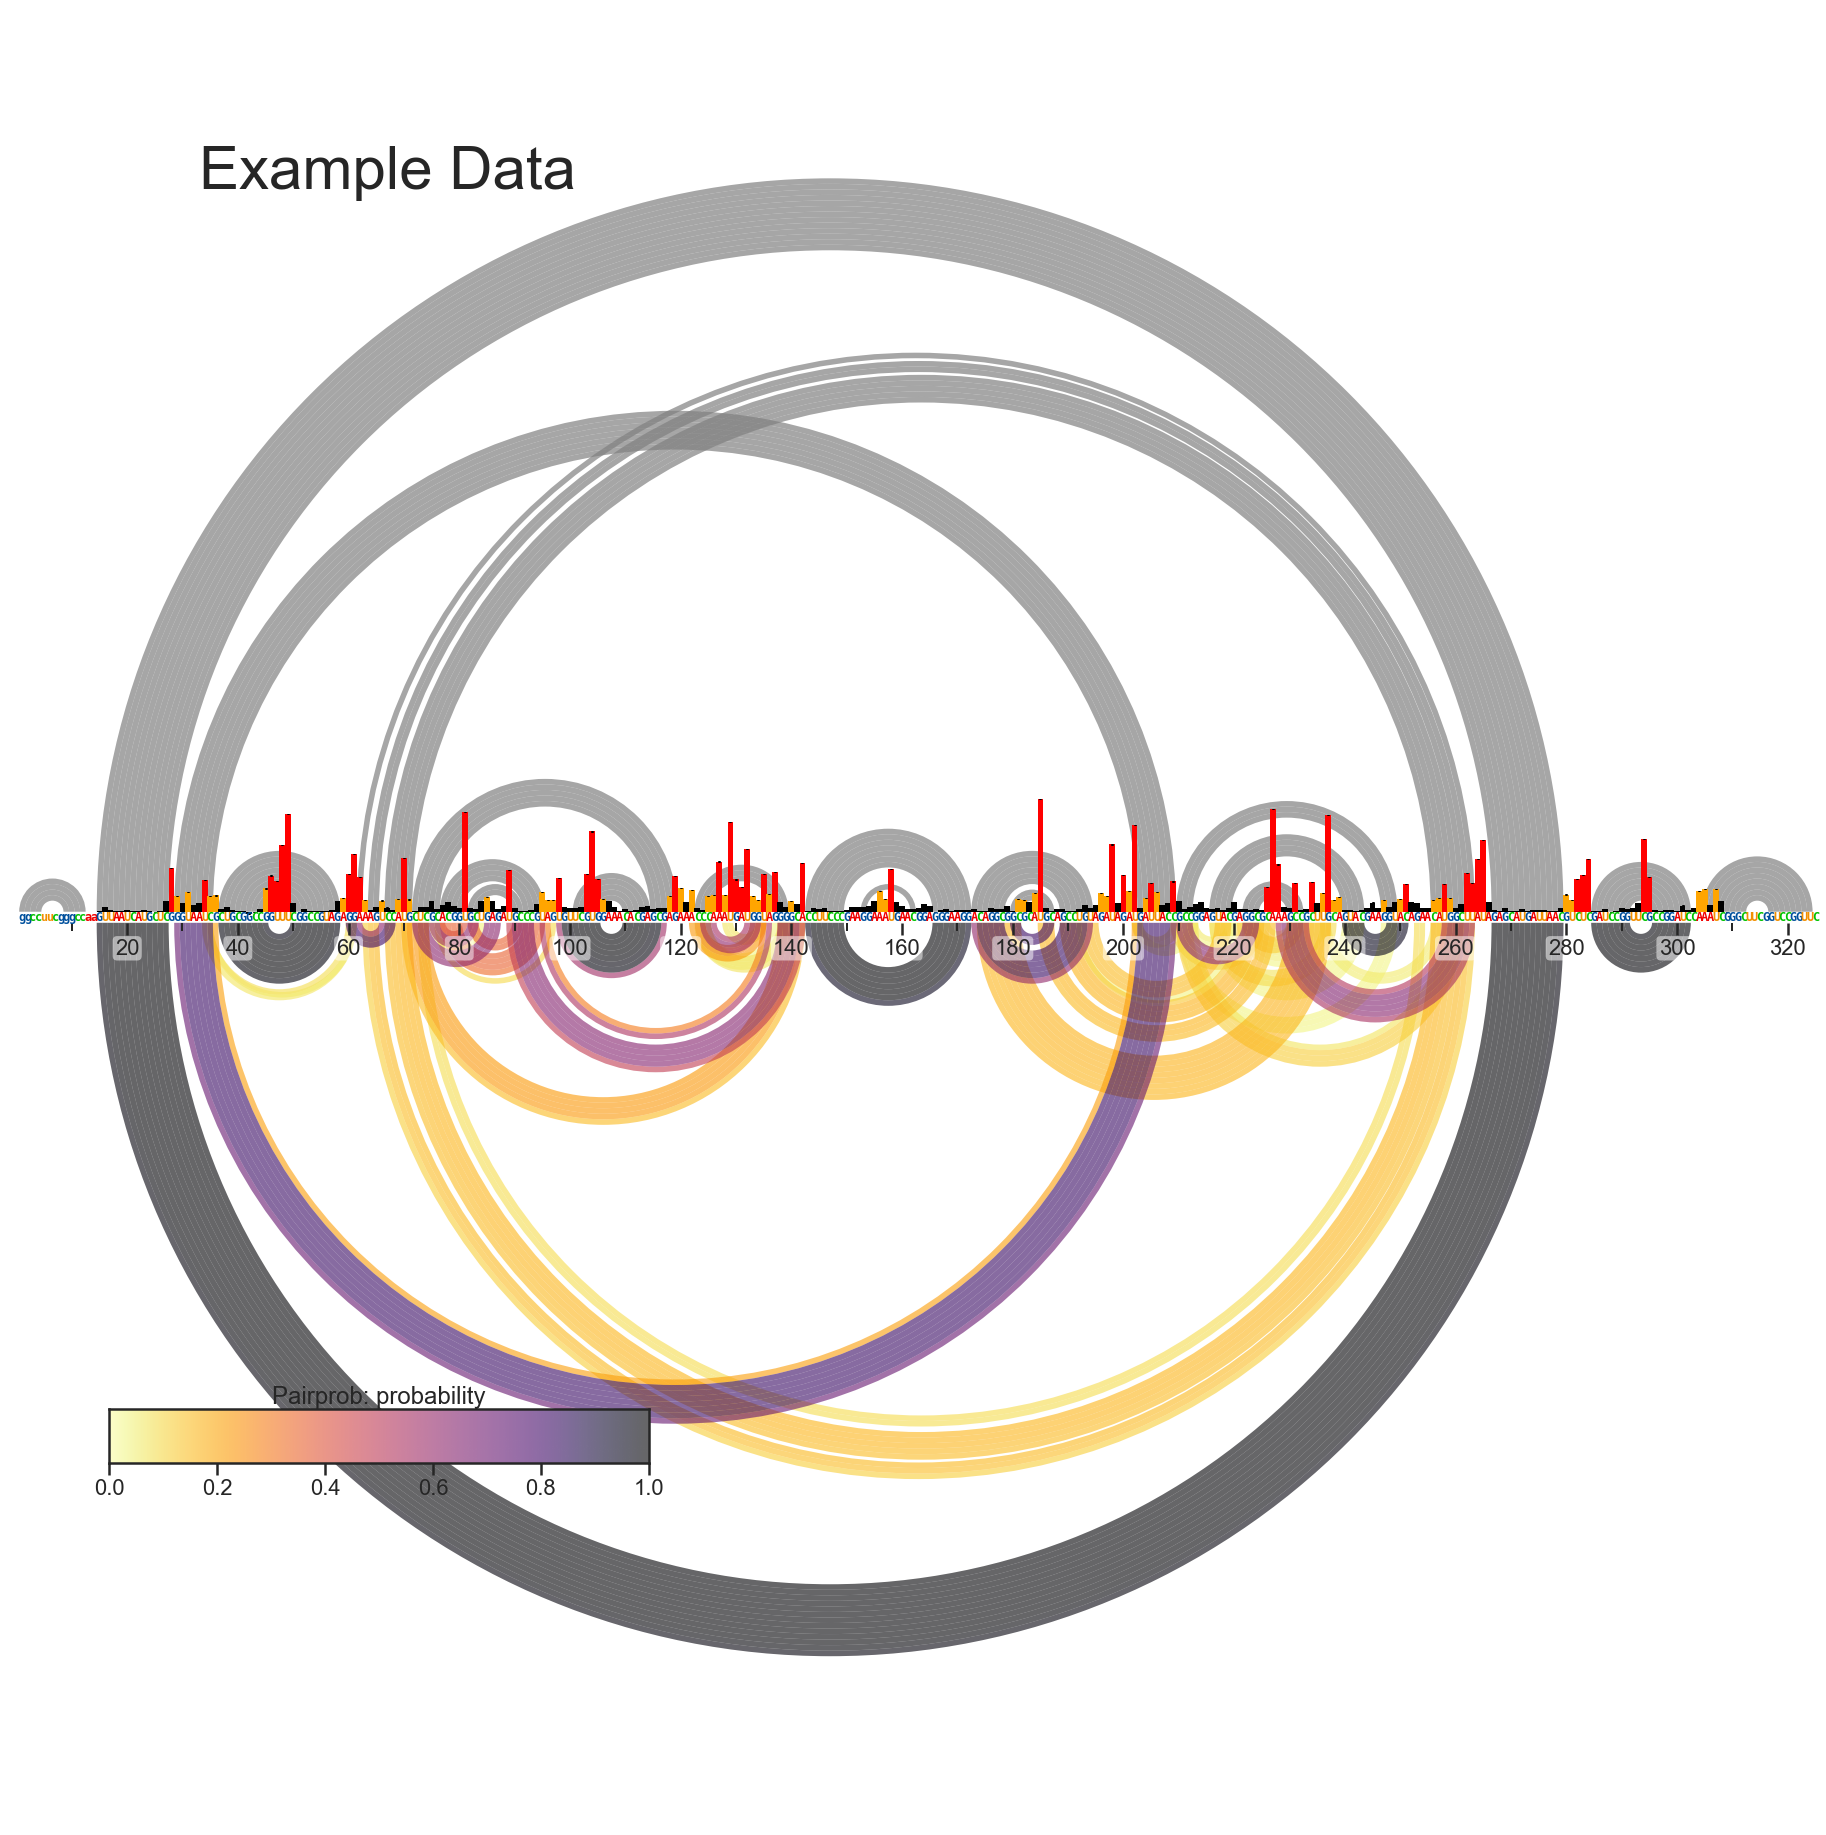

In [6]:
plot = example.plot_arcs(interactions="pairprob")

In earlier plots, I determined that these data should produce good
correlations. I'll take a look at my `ringmap` data here. These data are often
so we will apply some filters by passing them to `interactions_filter`.

`"positive_only": True` removes negative correlations. These can be hard to
interpret.

`"Statistic_ge": 23` means that the Gapc statistic of the correlation must be
greater than or equal to (`_ge`) 23, so we will only be looking at the
strongest signals.

`"cdAbove": 14` removes correlations that are close in secondary structure.
Contact distance (`cd`) refers to the number of steps through the secondary
structure graph between the two nucleotides of the correlation.

Using these filters in combination, a loop-loop interaction between
nucleotides 85 and 155 becomes apparent.

There are many other filters that can be applied to these data. See the data
filtering tutorial for a guide on how to use these.

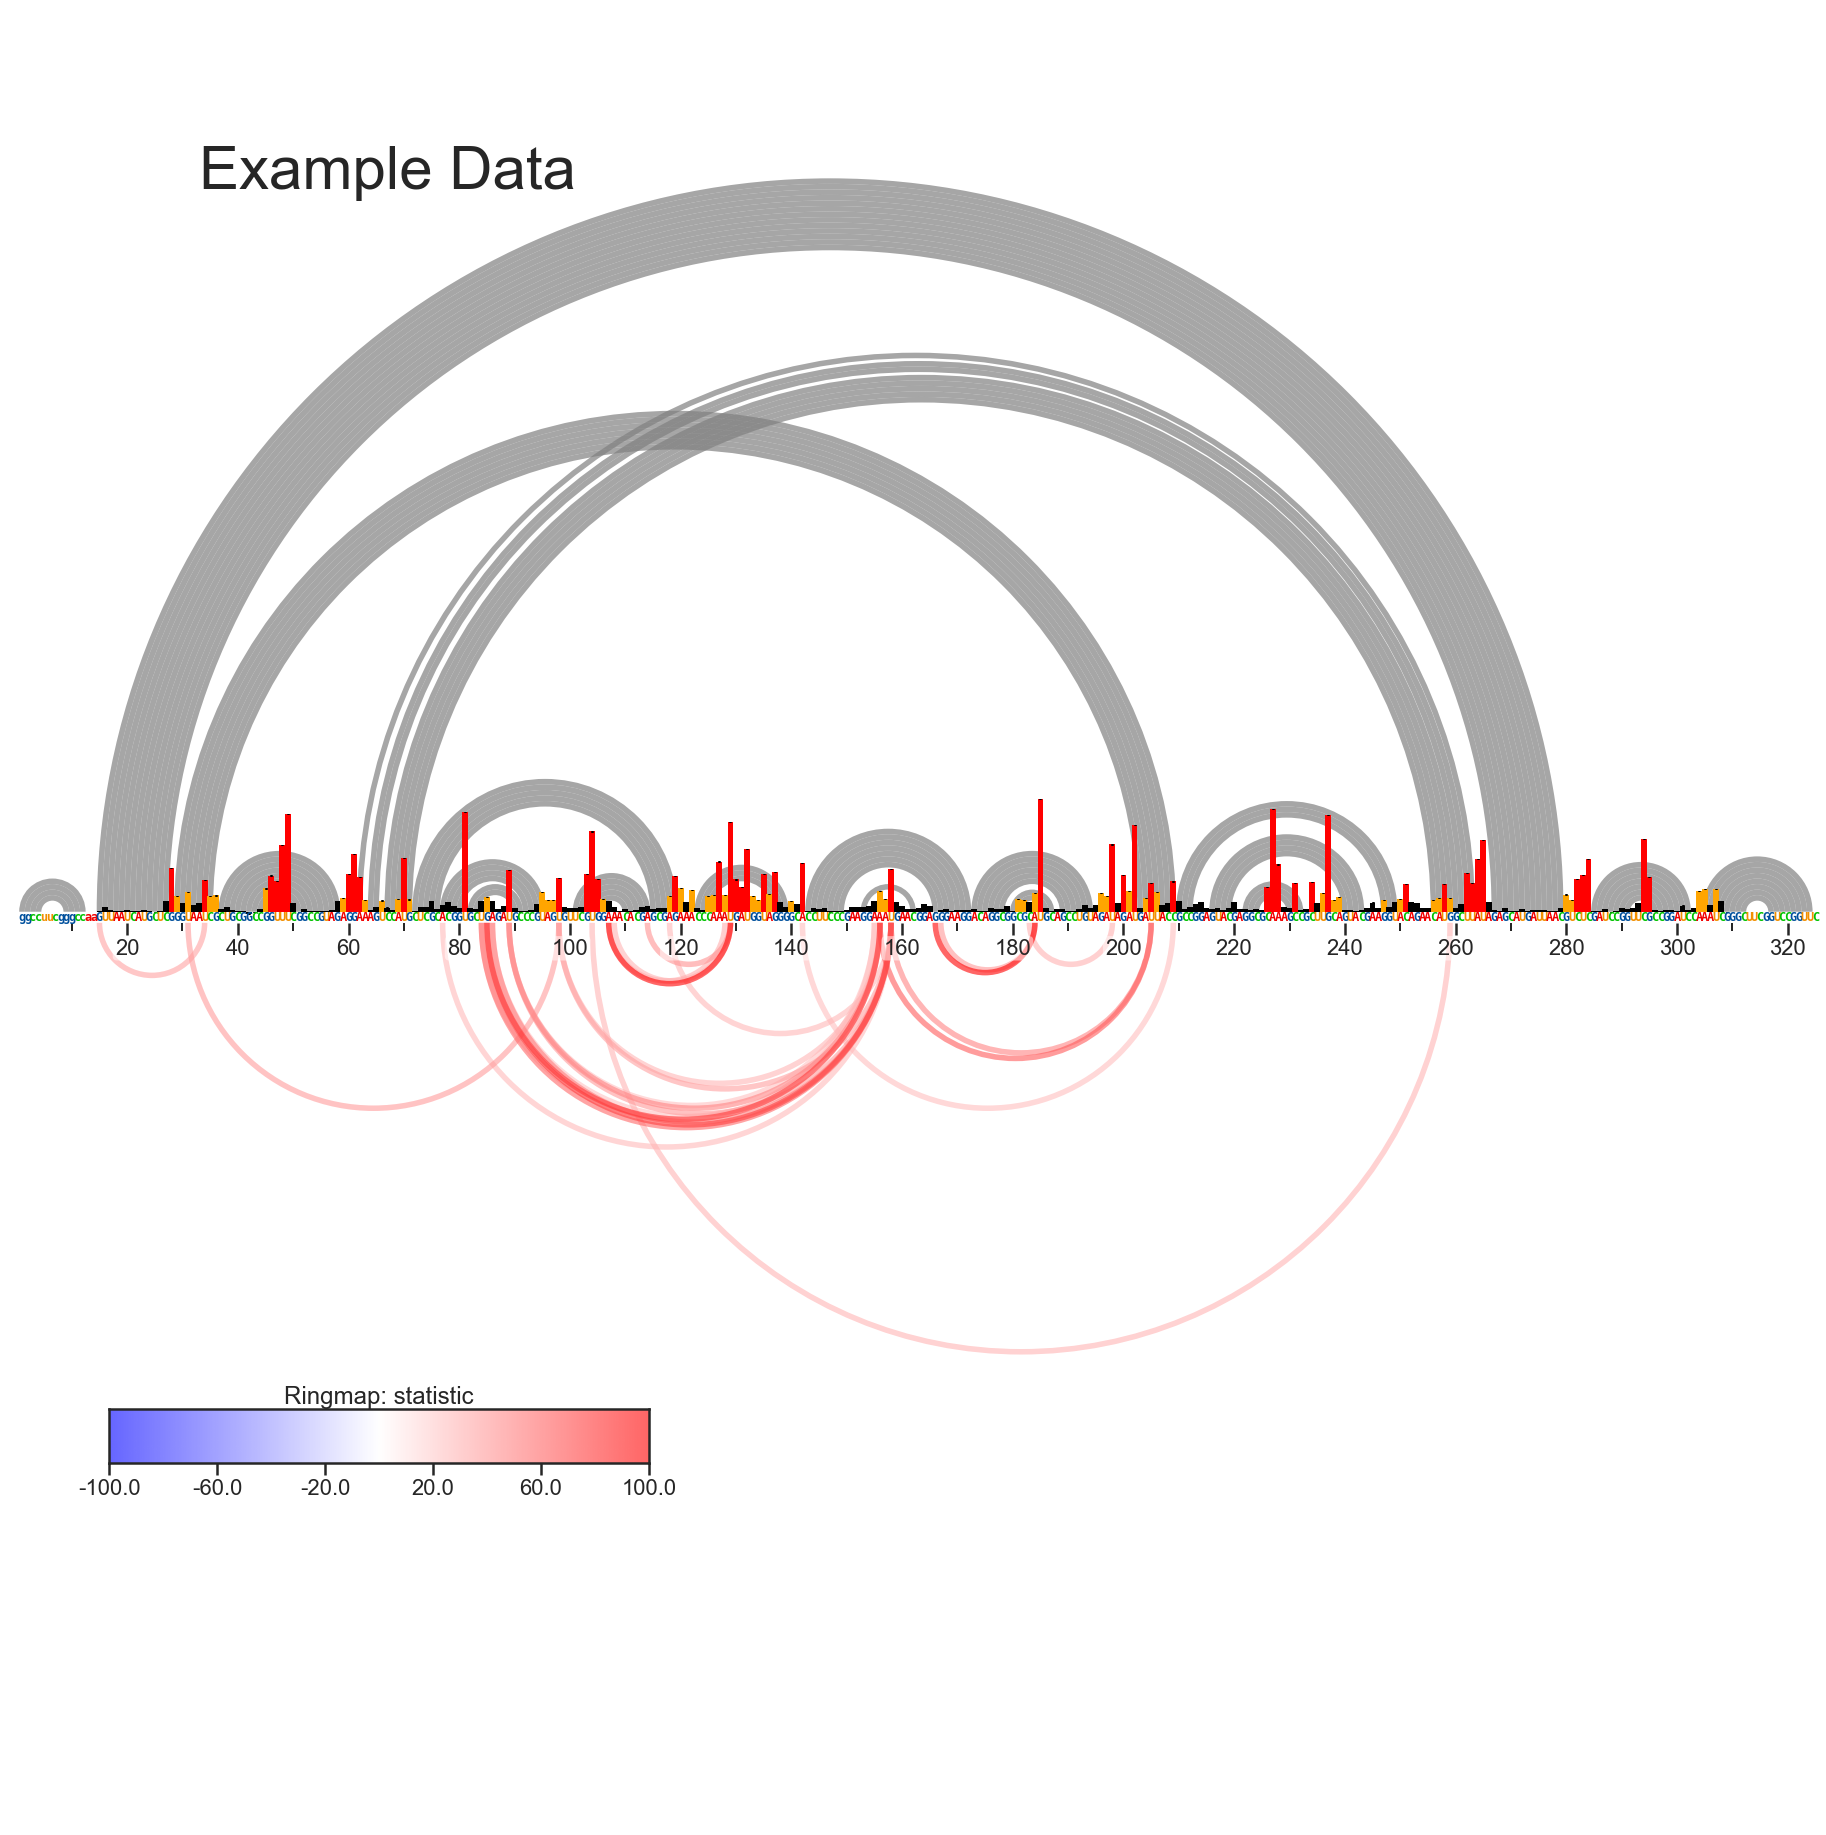

In [7]:
plot = example.plot_arcs(
    interactions="ringmap",
    interactions_filter={
        "positive_only": True,
        "Statistic_ge": 23,
        "cdAbove": 14})

### Circle plot

This type of plot is usually less clear than an arc plot, but it can be useful
in cases where we are mostly interested in one data type, and we need to fit an
arbitrarily large RNA in a square area.

This plot accepts the same filtering scheme used in the example above.

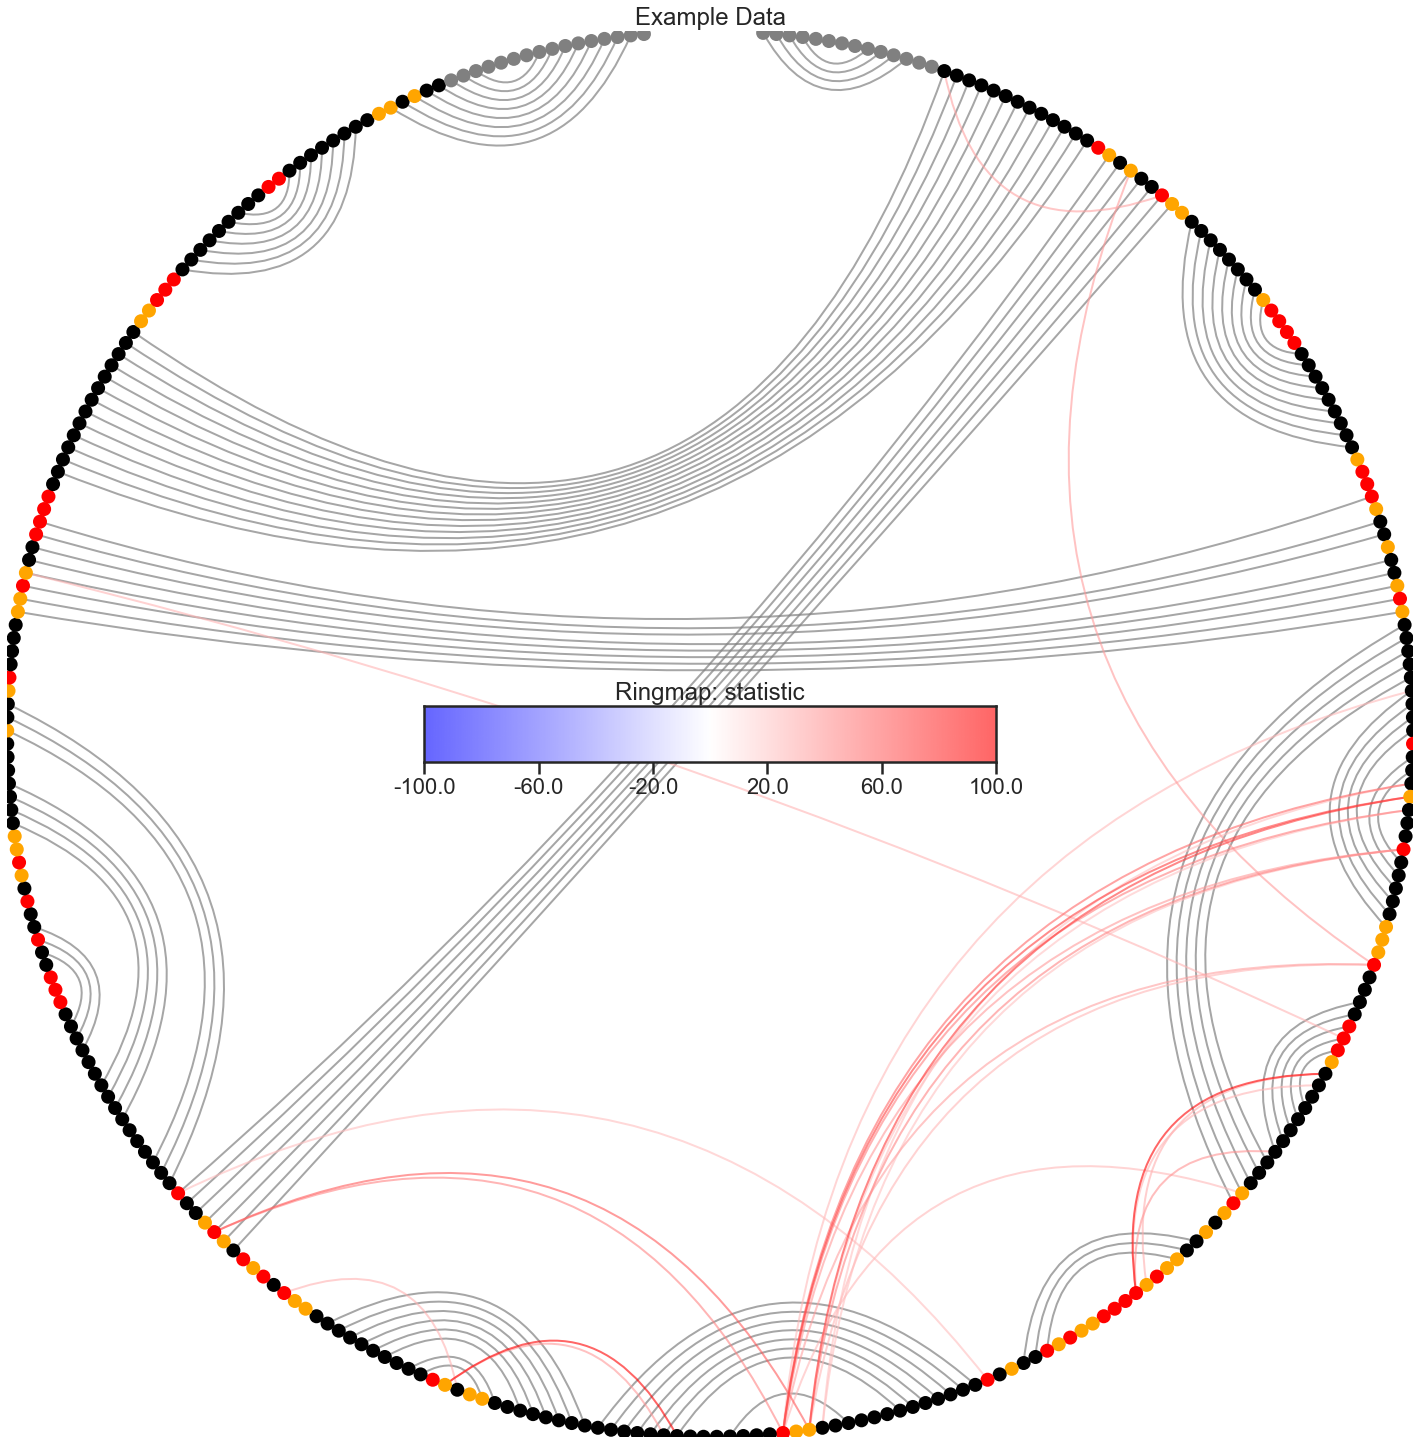

In [8]:
plot = example.plot_circle(
    ct="ct",
    profile="shapemap",
    interactions="ringmap",
    interactions_filter={
        "positive_only": True,
        "Statistic_ge": 23,
        "cdAbove": 14})

### Secondary structure diagrams

Another interesting way to display these data are on secondary structure
drawings. This particular drawing was custom drawn to resemble the tertiary
structure for this RNA. Here it it is very apparent that the loop-loop
interaction (between the bottom two loops) that we have been seeing is
informative of the true tertiary structure.

This plot also accepts the same filtering scheme used in the examples above.

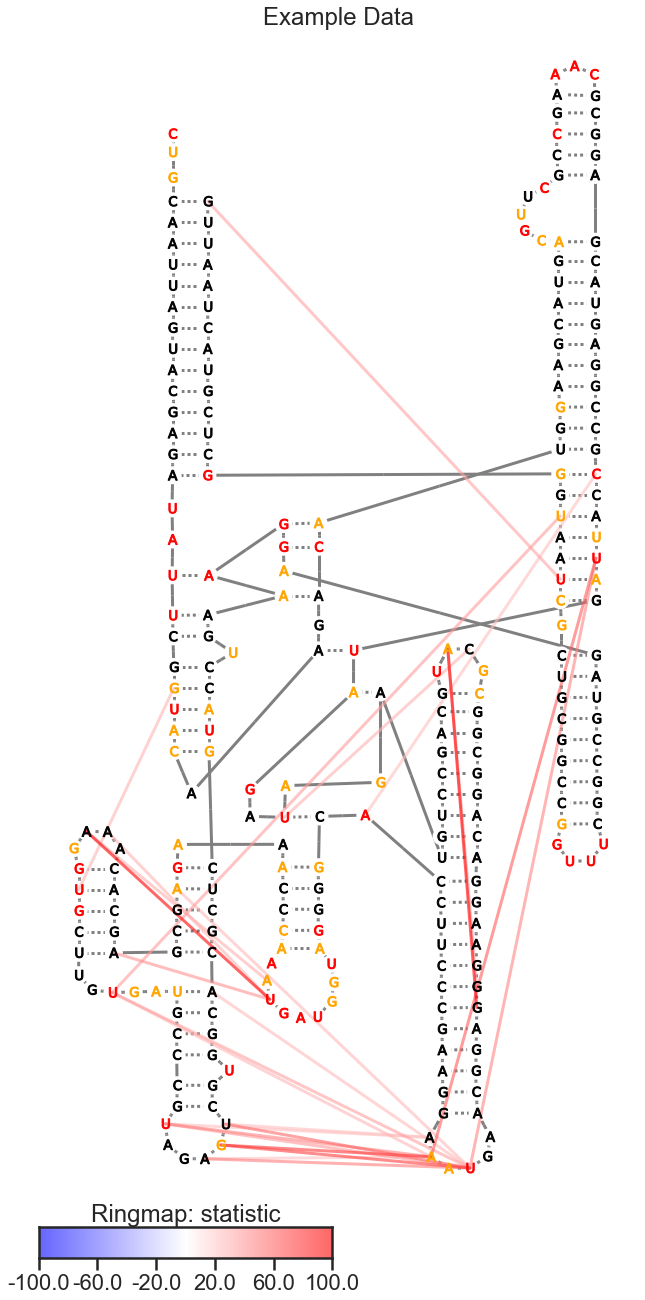

In [9]:
plot = example.plot_ss(
    interactions="ringmap",
    interactions_filter={
        "positive_only": True,
        "Statistic_ge": 23,
        "cdAbove": 14},
    profile="shapemap",
    colors="profile",
    apply_color_to="sequence")


### 3D molecule interactive plots

The above secondary structure drawing is very informative, but it was manually
drawn using XRNA, which can be a time-consuming process. Sometimes it is best
to simply plot these data directly on the 3D structure.

This plot also accepts the same filtering scheme used in the examples above.

Controls:

* click and drag to rotate
* mouse scroll or right click to zoom
* 3rd mouse button and drag to pan

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

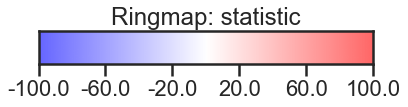

In [10]:
plot = example.plot_mol(
    interactions="ringmap",
    interactions_filter={
        "positive_only": True,
        "Statistic_ge": 23,
        "cdAbove": 14},
    nt_color="grey")


### Heatmap plot

In heatmap plots, X and Y are nucleotide positions, and information about the
relationships between nucleotide x and nucleotide y are shown.

The encircled regions below are showing areas that are close in space in my `pdb`.

The green "heatmap" here is actually a 2D KDE plot. It is showing the density
of rings. Here it is clear that the highest density regions are close in space.

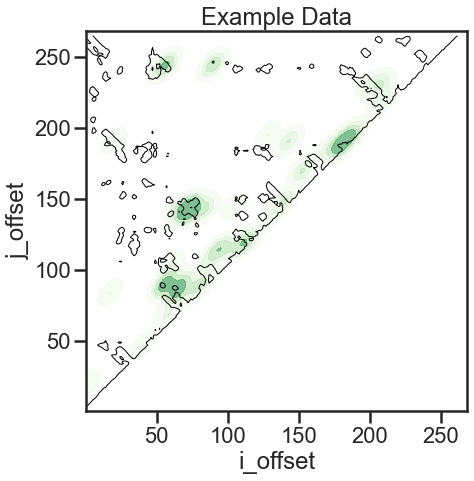

In [11]:
plot = example.plot_heatmap(
    structure="pdb",
    interactions="ringmap",
    interactions_filter={
        "positive_only": True,
        "cmap": "Greens"},
    plot_type='kde')

### Distance histograms

This plot can tell you if your interactions data is doing a good job of
reporting on feasible structural interactions. You want to see the blue bars
left-shifted compared to the grey line.

- Grey line: Pairwise 3D distances between all nucleotides in PDB
- Blue bars: 3D Distances RING-MaP data

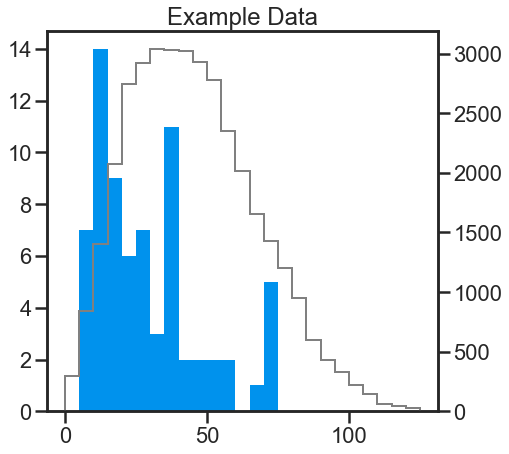

In [12]:
plot = example.plot_disthist(
    structure="pdb",
    interactions="ringmap",
    interactions_filter={
        "positive_only": True,
        "Statistic_ge": 23})